# GROUP 7 - Analytics and Applications

# Task 1: Data Collection and Preparation

In [226]:
import numpy as np 
import matplotlib.pyplot as plt     
import pandas as pd 
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_error, r2_score, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt







In [227]:
df = pd.read_csv("./Data/charging_sessions.csv")
df.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB


In [229]:
print(df.isnull().sum())

Unnamed: 0              0
id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4088
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17263
userInputs          17263
dtype: int64


Finding: The columns doneChargingTime, userID, and userInputs have missing values.

In [230]:
# Check for duplicates
print(df.duplicated().sum())


0


Finding: There are no duplicates

In [231]:
# Check for invalid values
print(df[df['kWhDelivered'] < 0]),       

Empty DataFrame
Columns: [Unnamed: 0, id, connectionTime, disconnectTime, doneChargingTime, kWhDelivered, sessionID, siteID, spaceID, stationID, timezone, userID, userInputs]
Index: []


(None,)

Finding: There are no values with kWhDelivered < 0

# Data Cleaning


### Remove the column "Unnamed: 0" 
The column has 66450 empty values. This is equivalent to the amount of rows of the dataset, therefore it does not provide any value and can be removed. 

In [232]:
df.drop(columns=['Unnamed: 0'], inplace=True)

### Replace "userID" na values with -1
There are 17263 data points with userID = na. Since this is a significant amount, removing the affected rows is not an option. 
To allow for further analysis in the upcoming milestones, it therefore makes sense to use a placeholder value.

In [233]:
df['userID'].fillna(-1, inplace=True)

### Remove "doneChargingTime" na values 
There are 4088 data points with doneChargingTime = na. 
Interpolation is not an option at this point, since it is very difficult to interpolate values for a metric that is dependent from connectionTime. By trying to estimate the doneChargingTime for missing entries based on the connectionTime of this entry and the average time of other loading processes, we could manipulate the dataset, because the battery could have different states of charge at the start of charging.

In [234]:
df.dropna(subset=['doneChargingTime'], inplace=True)

### Remove the column "timezone"
Every timezone is set to "America/Los_Angeles", therefore it does not provide any value for further analysis and can be removed. 

In [235]:
df.drop(columns=['timezone'], inplace=True)

### Split UserInput to multiple features
The values of userInputs include valuable insides which can be relevant for further analysis. 
To ease the analysis later, we created coumns for the features within the userInputs string. 

In [236]:

#Function to parse 'userInputs' & extract the first dictionary
def parse_user_inputs(row):
    try:
        parsed = ast.literal_eval(row) if pd.notnull(row) else []
        return parsed[0] if isinstance(parsed, list) and len(parsed) > 0 else {}
    except (ValueError, SyntaxError):
        return {}

#Parse 'userInputs' column
df['userInputs'] = df['userInputs'].apply(parse_user_inputs)

#Specify desired features
desired_features = [
    'WhPerMile', 'kWhRequested', 'milesRequested', 
    'minutesAvailable', 'modifiedAt', 'paymentRequired', 
    'requestedDeparture'
]

#Extract desired features and create new columns
for feature in desired_features:
    df[feature] = df['userInputs'].apply(lambda x: x.get(feature) if isinstance(x, dict) else None)

#Drop the 'userInputs' column since it is no longer needed
df = df.drop(columns=['userInputs'])



## Convert time metrices and calculate hours 
For further analysis it is easier to work with dateTime objects. Also it is necessary to calculate the hours.

In [237]:

df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

#Calculate durations in hours
df['charging_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600

In [238]:
df.head()
df.info()
df["connectionTime"].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62362 entries, 0 to 66449
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  62362 non-null  object             
 1   connectionTime      62362 non-null  datetime64[ns, UTC]
 2   disconnectTime      62362 non-null  datetime64[ns, UTC]
 3   doneChargingTime    62362 non-null  datetime64[ns, UTC]
 4   kWhDelivered        62362 non-null  float64            
 5   sessionID           62362 non-null  object             
 6   siteID              62362 non-null  int64              
 7   spaceID             62362 non-null  object             
 8   stationID           62362 non-null  object             
 9   userID              62362 non-null  float64            
 10  WhPerMile           46008 non-null  float64            
 11  kWhRequested        46008 non-null  float64            
 12  milesRequested      46008 non-nu

0

# Uncover relationships and outliers

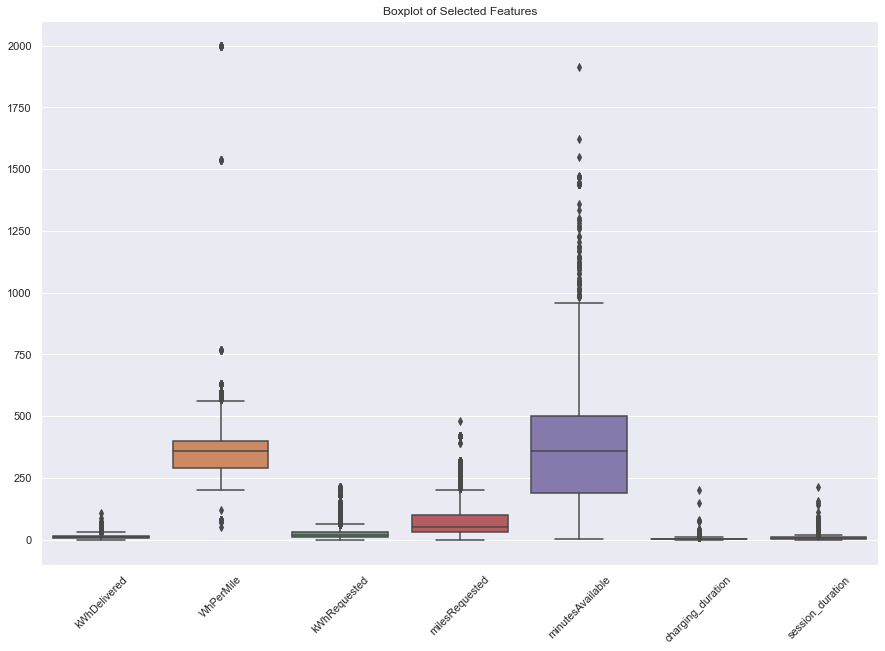

In [239]:
# List of columns to check for outliers
columns_to_check = [
    'kWhDelivered', 'WhPerMile', 'kWhRequested', 
    'milesRequested', 'minutesAvailable', 'charging_duration', 'session_duration'
]

# Remove one datapoint that is a strong outlier
df = df[df['minutesAvailable'] <= 8000]

# Create a boxplot for the specified features
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[columns_to_check])
plt.title('Boxplot of Selected Features')
plt.xticks(rotation=45)
plt.show()





with one exeption there are no strong outliers in the data as seen in the boxplot visualizations and the models can deal with some outlieres. Therefor we do not need more deletion of outliers

To uncover as many relationships in the dataset as possible and get awareness of outliers, we use a pairplot. We intentionally excluded time-based features, categorical data, and unique identifiers, as they are not continuous numerical variables and would not contribute meaningful patterns to the pair plot analysis.

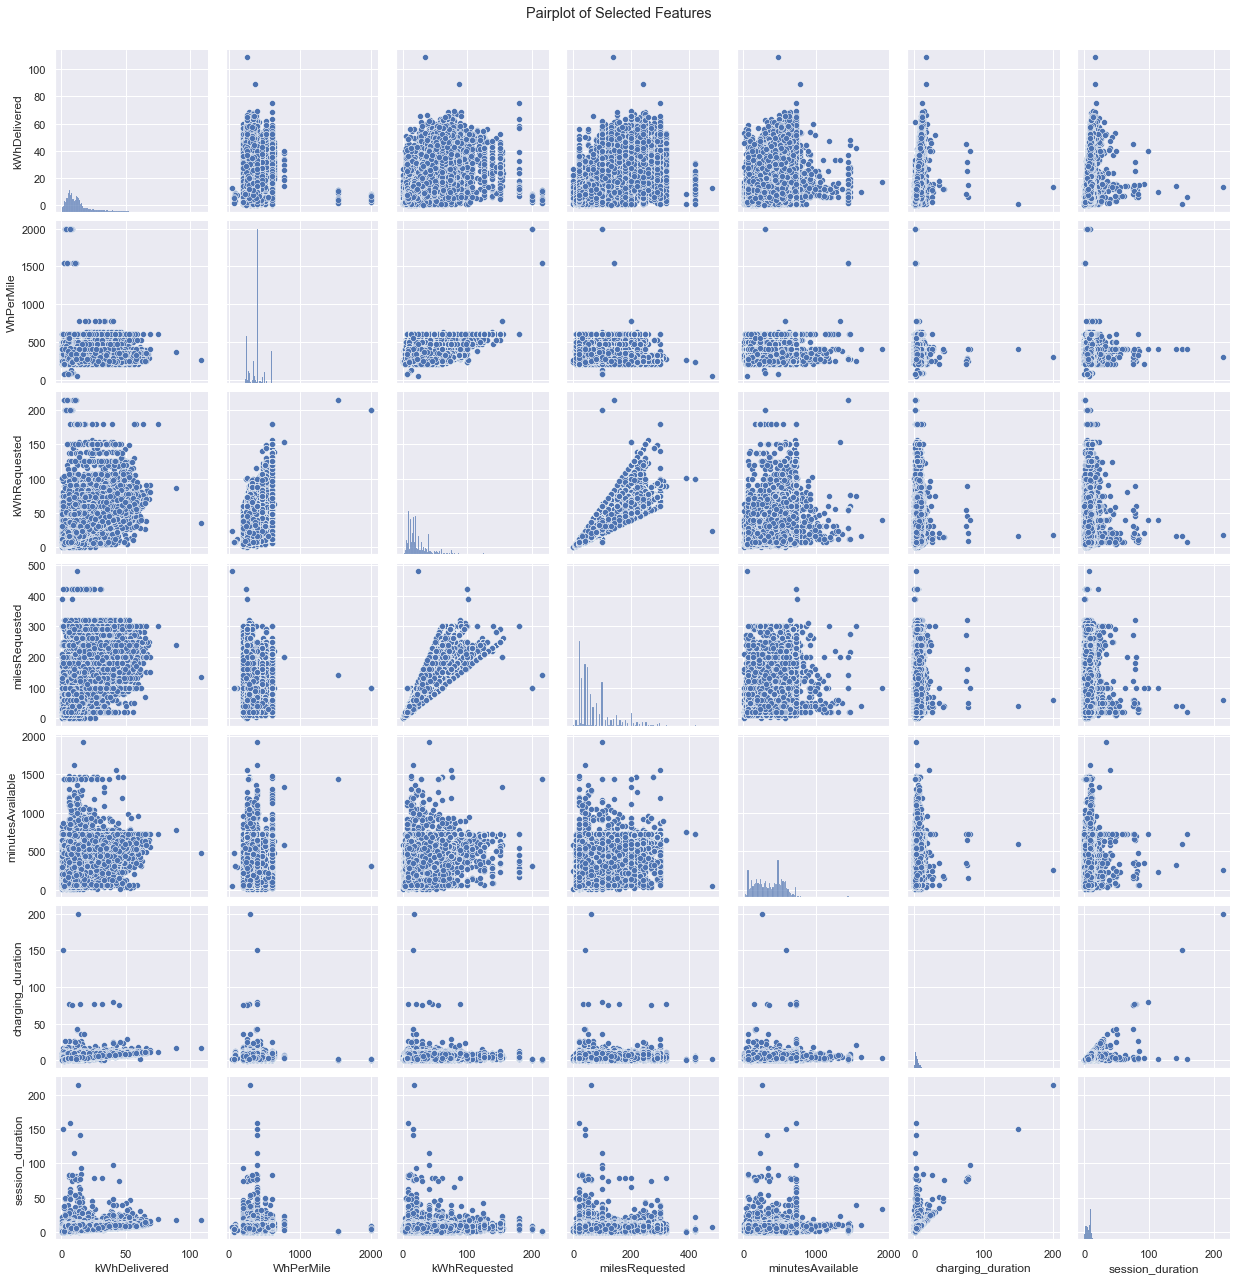

In [240]:
columns_for_pairplot = [
    'kWhDelivered', 'WhPerMile', 'kWhRequested', 
    'milesRequested', 'minutesAvailable', 'charging_duration', 'session_duration'
]

sns.pairplot(df[columns_for_pairplot])
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

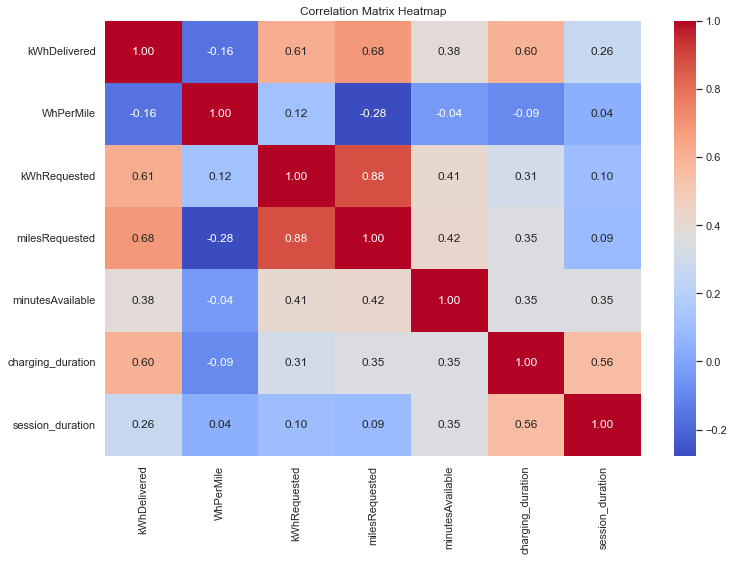

In [241]:
# Corr. matrix
numeric_df = df[columns_for_pairplot].select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

The correlation matrix heatmap shows a strong positive correlation between kWhRequested and milesRequested (0.88), indicating that the amount of energy requested is closely related to the distance requested. Longer trips generally require more energy, and users who travel more kilometers tend to request more kWh.

Similarly, kWhDelivered and milesRequested (0.68) show that as distance increases, energy delivered also increases, showing the direct relationship between distance and energy demand. Users who want to cover a longer distance naturally require more energy for their journey, which leads to a higher delivered kWh.

The correlation between kWh delivered and kWh demanded (0.61) suggests that the energy delivered generally matches the energy demanded, although there may be some variation due to factors such as charging efficiency. In most cases, the amount of energy requested and the amount of energy supplied match accurately.

# Task 2: Descriptive Analytics

## A)

In [242]:
#Hour of Day
df["hour"] = df['connectionTime'].dt.hour

#Day of Week (Monday=0, Sunday=6)
df["dayOfWeek"] = df['connectionTime'].dt.dayofweek

#Month
df["month"] = df['connectionTime'].dt.month

#Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df["season"] = df['month'].apply(get_season)
hourly_counts = df.groupby('hour').size().reset_index(name='Charging Events')

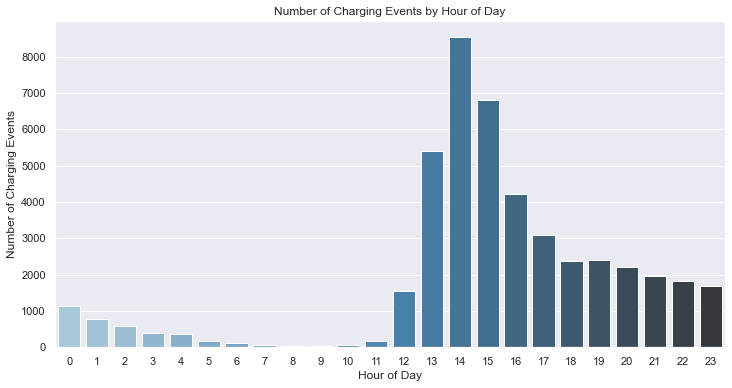

In [243]:
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=hourly_counts, palette='Blues_d')
plt.title('Number of Charging Events by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

### Mapping day numbers to names

In [244]:
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df['dayName'] = df['dayOfWeek'].map(day_names)

weekly_counts = df.groupby('dayName').size().reset_index(name='Charging Events')

### Ensure the days are in the correct order

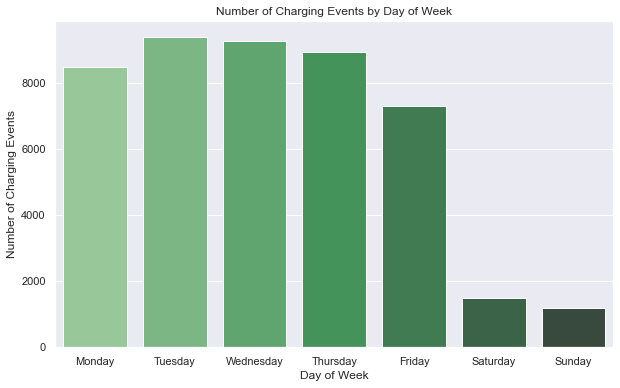

In [245]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts['dayName'] = pd.Categorical(weekly_counts['dayName'], categories=order, ordered=True)
weekly_counts = weekly_counts.sort_values('dayName')

plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Charging Events', data=weekly_counts, palette='Greens_d')
plt.title('Number of Charging Events by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.show()

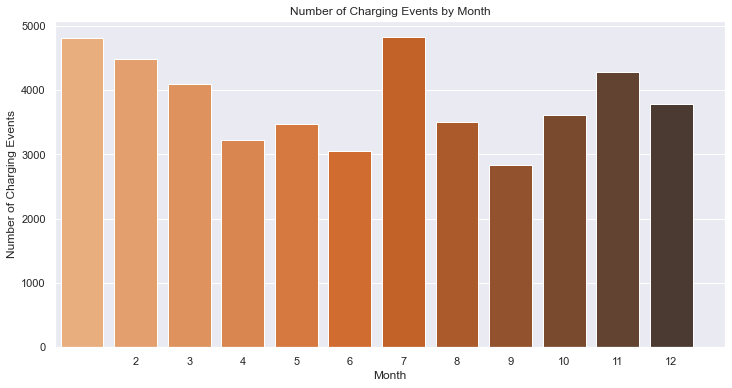

In [246]:
monthly_counts = df.groupby('month').size().reset_index(name='Charging Events')
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='Charging Events', data=monthly_counts, palette='Oranges_d')
plt.title('Number of Charging Events by Month')
plt.xlabel('Month')
plt.ylabel('Number of Charging Events')
plt.xticks(range(1, 13))
plt.show()

## B)

### KPI 1: Energy delivered per hour
This KPI is important because it provides a good overview of the hubs activity/how much energy is being utalized. 
It reflects the overall demand for charging services, which is directly tied to revenue (assuming a pricing model per kWh). Trends can be used for further forcasting the demand in the future. 

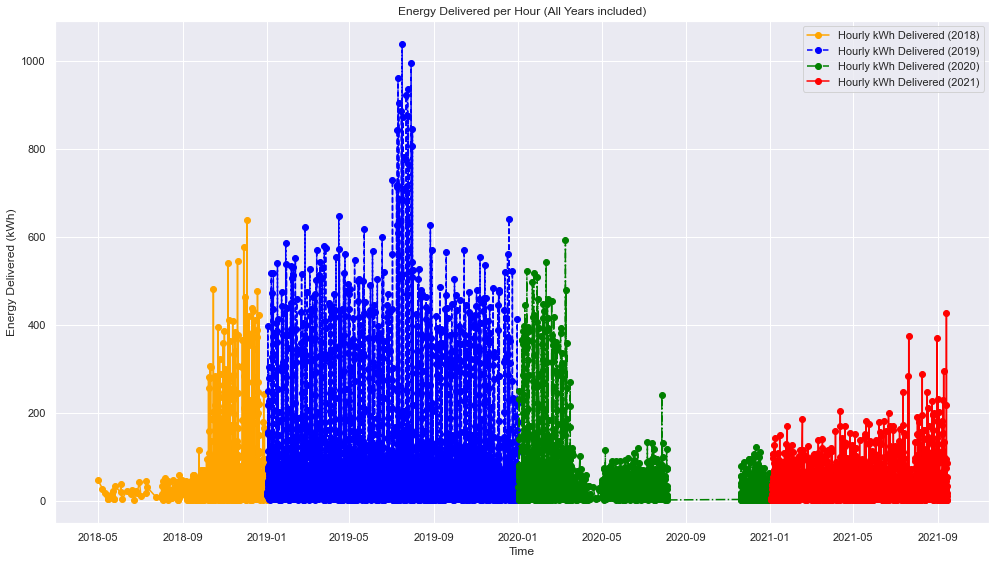

In [247]:
df['year'] = df['connectionTime'].dt.year
df['hour'] = df['connectionTime'].dt.floor('H')

# Group data by year & hour for the hourly energy delivered
yearly_data = df.groupby(['year', 'hour']).agg(
    energy_delivered=('kWhDelivered', 'sum')
).reset_index()

# Plot energy delivered per hour for all years in rthe df
fig, ax = plt.subplots(figsize=(14, 8))

# Set colors for each year in df to make it visually differentiable
colors = ['orange', 'blue', 'green', 'red']
line_styles = ['-', '--', '-.', '-']

# Loop through each year to plot
for idx, year in enumerate(sorted(yearly_data['year'].unique())):
    year_subset = yearly_data[yearly_data['year'] == year]
    
    # Plot hourly energy delivered
    ax.plot(
        year_subset['hour'], 
        year_subset['energy_delivered'], 
        marker='o', 
        linestyle=line_styles[idx % len(line_styles)], 
        color=colors[idx % len(colors)], 
        label=f'Hourly kWh Delivered ({year})'
    )

ax.set_title('Energy Delivered per Hour (All Years included)')
ax.set_xlabel('Time')
ax.set_ylabel('Energy Delivered (kWh)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


#### Since the chart has too many data points included, it is necessary to split the chart into multiple ones for better interpretability. For each year, one chart is included. Additionally to the kWhDelivered, mean value is included for each day.

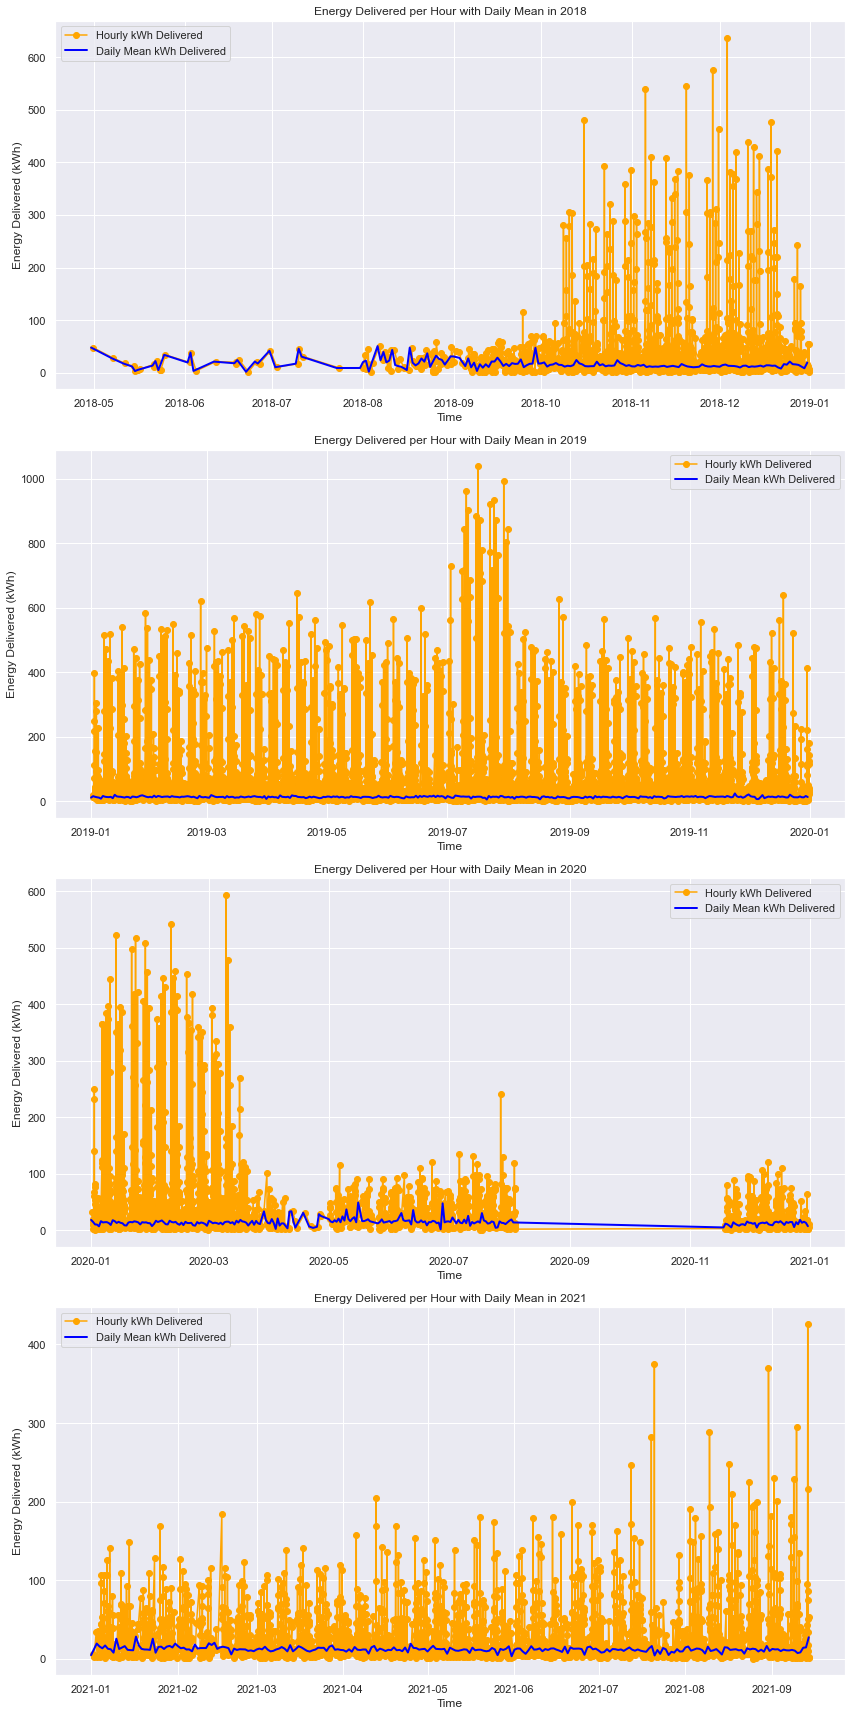

In [248]:
df['day'] = df['connectionTime'].dt.date

# Group data by year and hour for the hourly energy delivered
yearly_data = df.groupby(['year', 'hour']).agg(
    energy_delivered=('kWhDelivered', 'sum')
).reset_index()

# Calculate the mean kWh delivered/day
daily_mean_data = df.groupby(['year', 'day']).agg(
    daily_mean_kwh=('kWhDelivered', 'mean')
).reset_index()
daily_mean_data['day'] = pd.to_datetime(daily_mean_data['day'])

# Plot energy delivered per hour with daily mean overlay for each year
unique_years = yearly_data['year'].unique()
fig, axes = plt.subplots(len(unique_years), 1, figsize=(12, 6 * len(unique_years)))

for i, year in enumerate(unique_years):
    # Data for current year
    year_subset = yearly_data[yearly_data['year'] == year]
    daily_mean_subset = daily_mean_data[daily_mean_data['year'] == year]
    # Plot  hourly kWhdelivered
    axes[i].plot(year_subset['hour'], year_subset['energy_delivered'], marker='o', color='orange', label='Hourly kWh Delivered')
    # Plot the daily mean of kWhdelivered
    axes[i].plot(daily_mean_subset['day'], daily_mean_subset['daily_mean_kwh'], color='blue', linewidth=2, label='Daily Mean kWh Delivered')
    
    axes[i].set_title(f'Energy Delivered per Hour with Daily Mean in {year}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Energy Delivered (kWh)')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Since there is anomaly in the data between August and mid November, further investigation is necessary. 

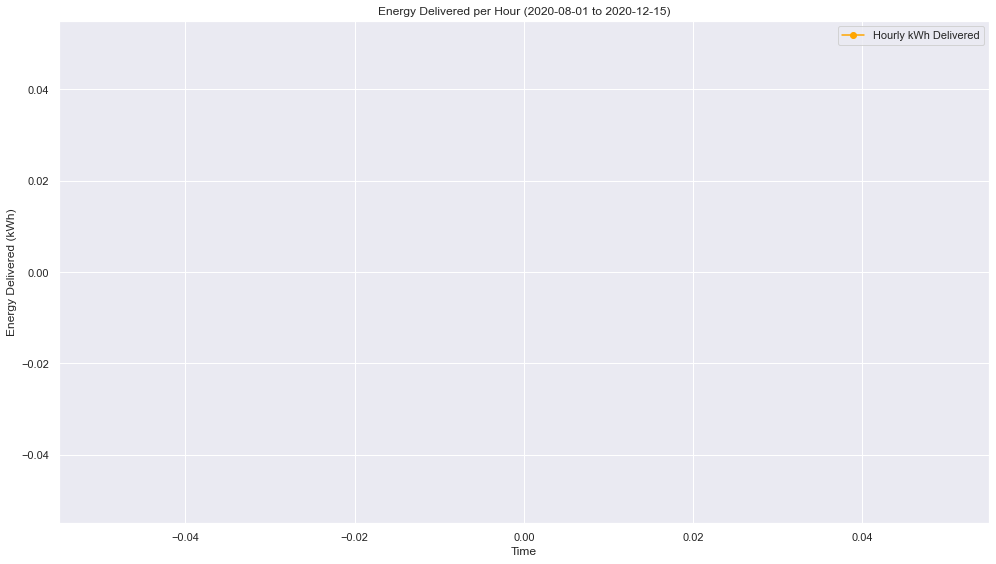

In [249]:
# Filter data for the specified time range
filtered_data = df[
    (df['connectionTime'] >= '2020-08-04') & 
    (df['connectionTime'] <= '2020-11-17')
]

filtered_data['hour'] = filtered_data['connectionTime'].dt.floor('H')

# Group data by hour for the filtered range
filtered_hourly_data = filtered_data.groupby(['hour']).agg(
    energy_delivered=('kWhDelivered', 'sum')
).reset_index()

# Plot the filtered data
fig, ax = plt.subplots(figsize=(14, 8))

# Plot hourly energy delivered
ax.plot(
    filtered_hourly_data['hour'], 
    filtered_hourly_data['energy_delivered'], 
    marker='o', 
    color='orange', 
    label='Hourly kWh Delivered'
)
ax.set_title('Energy Delivered per Hour (2020-08-01 to 2020-12-15)')
ax.set_xlabel('Time')
ax.set_ylabel('Energy Delivered (kWh)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [250]:
specific_range_data = filtered_data[
    (filtered_data['connectionTime'] >= '2020-08-04') & 
    (filtered_data['connectionTime'] <= '2020-11-17')
][['connectionTime', 'kWhDelivered']]
zero_values_count = specific_range_data['kWhDelivered'].eq(0).sum()
null_values_count = specific_range_data['kWhDelivered'].isnull().sum()



average_kwh = specific_range_data['kWhDelivered'].mean()
median_kwh = specific_range_data['kWhDelivered'].median()
# Display the filtered kWhDelivered values
average_kwh, median_kwh

excluded_data = df[
    (df['connectionTime'] < '2020-08-04') 
    | 
    (df['connectionTime'] > '2020-11-17')
]

# Calculate the average and median kWhDelivered for the excluded range
average_kwh_excluded = excluded_data['kWhDelivered'].mean()
median_kwh_excluded = excluded_data['kWhDelivered'].median()

# Display the results
average_kwh_excluded, median_kwh_excluded

print(zero_values_count,null_values_count,average_kwh_excluded, median_kwh_excluded, average_kwh, median_kwh)

0 0 13.332532715640083 10.325 nan nan


## KPI 2: Users with/without User-Account over time

This Metric helps to identify the change over time of Users that have an User Account. User with an account are more helpfull because with them, the manager can generate more data about typical user groups and how users charge their cars(When, How much, How often, Where,...) That creates user profiles that are very hepfull to improve the charging infractructure and improve the locations and measures of the charging stations, to improve the profitability and capacity utilization per station. With that the manager can decide if more efforts are important to higher the number of registrered users or if spefific happenings higher the proportion of registered users.

c:\Users\Lucas\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


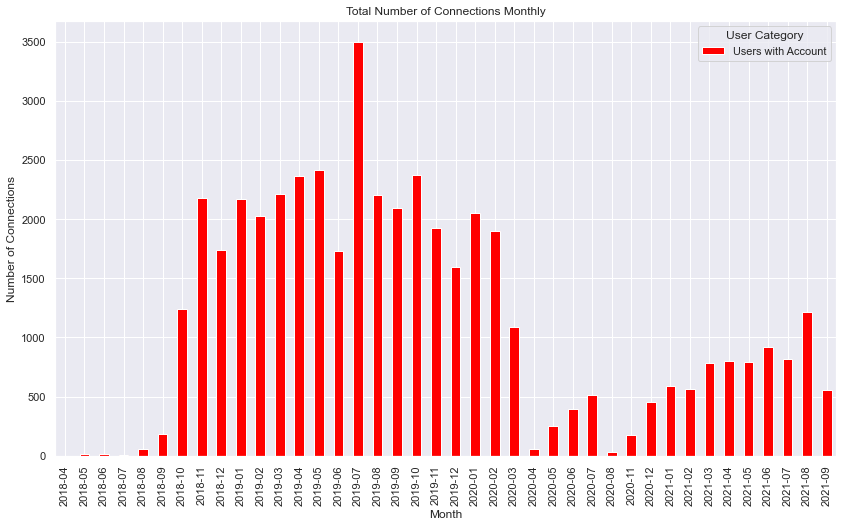

In [251]:
# Create a new column to categorize userID
df['user_category'] = df['userID'].apply(lambda x: 'Users without Account' if x == -1 else 'Users with Account')

# Group by month and user category to get the count of connections
monthly_user_counts = df.groupby([df['connectionTime'].dt.to_period('M'), 'user_category']).size().reset_index(name='Connections')

# Pivot the data to have user categories as columns
monthly_user_counts_pivot = monthly_user_counts.pivot(index='connectionTime', columns='user_category', values='Connections').fillna(0)

# Plot the data
monthly_user_counts_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), color=['red', 'blue'])
plt.title('Total Number of Connections Monthly')
plt.xlabel('Month')
plt.ylabel('Number of Connections')
plt.legend(title='User Category')
plt.show()

# Observation regarding missing kWhDelivered 
-The data between 04.08.2020 and 17.11.2020 has an average kWhDelivered of nan and mean of nan, while it is 11.643983837361155 and 9.029 on the whole dataset excluding this time range. Further investigation on why there are no values for kWhDelivered are available is necessary. 

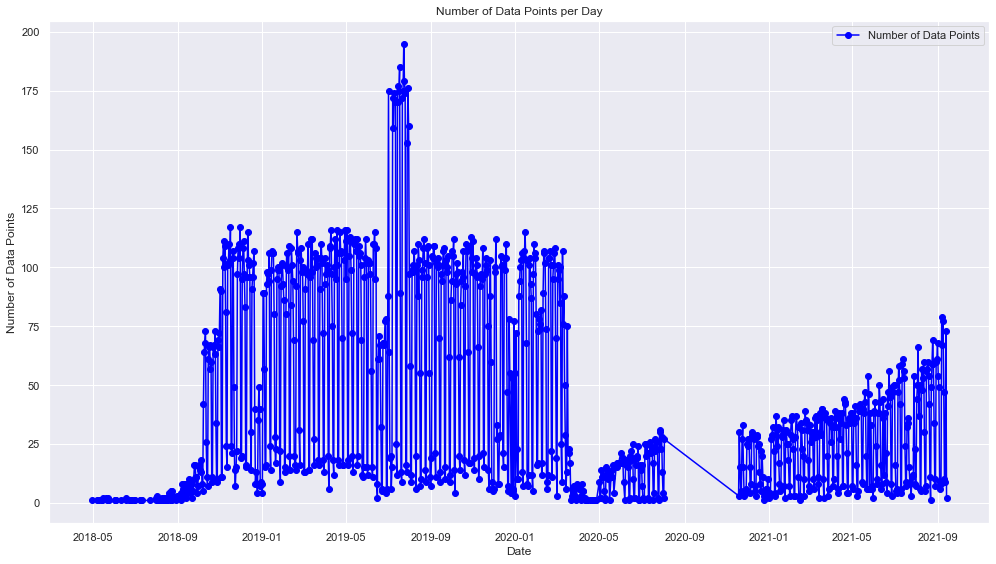

In [252]:
# Group by date to count the number of data points per day
data_points_per_day = df.groupby(df['connectionTime'].dt.date).size().reset_index(name='data_points')

# Plot the number of data points over time
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    data_points_per_day['connectionTime'], 
    data_points_per_day['data_points'], 
    marker='o', 
    linestyle='-', 
    color='blue',
    label='Number of Data Points'
)

# Chart labels, legend, and grid
ax.set_title('Number of Data Points per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Data Points')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [253]:
# Verify if any data exists between 2020-08-04 and 2020-11-17
missing_period_data = df[
    (df['connectionTime'] >= '2020-08-04') & 
    (df['connectionTime'] <= '2020-11-17')
]

# Count the number of records in this range
missing_period_count = missing_period_data.shape[0]

# Display the result
print(missing_period_count)

0


### Observation regarding missing data: 
There are no data points between the 04.08.2020 and 17.11.2020. There could be a major reason: 
COVID-19 came with travel restrictions, lockdown and layoffs led to a radical decrease in mobility. 
This could have led to the closure of multiple stations
### Observations regarding the kWh Delivered over the whole timespan of the dataset
#### 2018
The energy delivered starts relativly low. The gradual increase over time can have these reasons: 
1. Increased demand because of more users having an EV 
2. Increased awareness of available charging stations 
#### 2019
There is a significant growth in delivered energy compared to 2018. A noticable peak is in the July and August, which aligns with the increased number of charging events detected in task 2a). 
#### 2020 
A hard decline is noticable in this year, noticably strong after the early year. The reason for that could be COVID-19.
#### 2021
Energy delivered begins to rebound, showing growth over time. Although delivery levels remain lower than in 2019, there is a upward trend, indicating:
1. Recovery of demand post-pandemic
2. Gradual return of regular charging behavior
3. Increasing adoption of electric vehicles

## KPI 3: Utilization Rate

The utilization rate measures how often the charging station is in use versus idle. This KPI is crucial for assessing the demand for charging services and ensuring operational efficiency. A high utilization rate indicates that the charging station is in high demand, suggesting the need to maintain or potentially expand charging capacity in the area. Conversely, a persistently low utilization rate might highlight inefficiencies or suboptimal placement of the charging station. By tracking the utilization rate, the operator can monitor demand patterns, infrastructure limitations, and user behavior.

$$
\text{Utilization Rate} = \frac{\text{time charging stations were in use}}{\text{total time available for use}}
$$

In [254]:
# Calculates the utilization rate of charging stations for a given date
def calculate_utilization_rate(df, date):
    ef = df[df['connectionTime'].dt.date == pd.to_datetime(date).date()]
    total_stations = df['stationID'].nunique()
    time_stations_open_a_day = 24
    total_available_time = total_stations * time_stations_open_a_day
    total_occupied_time_per_station = ef.groupby('stationID')['session_duration'].sum()
    total_occupied_time_per_station = total_occupied_time_per_station.apply(lambda x: min(x, 24))
    total_occupied_time = total_occupied_time_per_station.sum()
    utilization_rate = (total_occupied_time / total_available_time) * 100
    return utilization_rate

# Calculate utilization rate for each day
def calculate_daily_utilization_rate(df):
    daily_utilization = []
    unique_dates = df['connectionTime'].dt.date.unique()
    
    for date in unique_dates:
        utilization_rate = calculate_utilization_rate(df, date)
        daily_utilization.append({'date': date, 'utilization_rate': utilization_rate})
    
    return pd.DataFrame(daily_utilization)

print(calculate_daily_utilization_rate(df))

            date  utilization_rate
0     2020-01-02         18.033212
1     2020-01-03          4.794918
2     2020-01-04          2.172972
3     2020-01-05          0.814815
4     2020-01-06         26.673909
...          ...               ...
1030  2019-06-25         20.527028
1031  2019-06-26         20.494533
1032  2019-06-27         22.474052
1033  2019-06-28         21.103946
1034  2019-06-29          0.643981

[1035 rows x 2 columns]


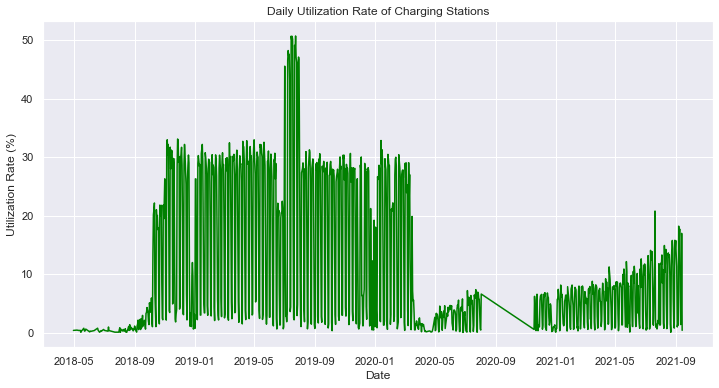

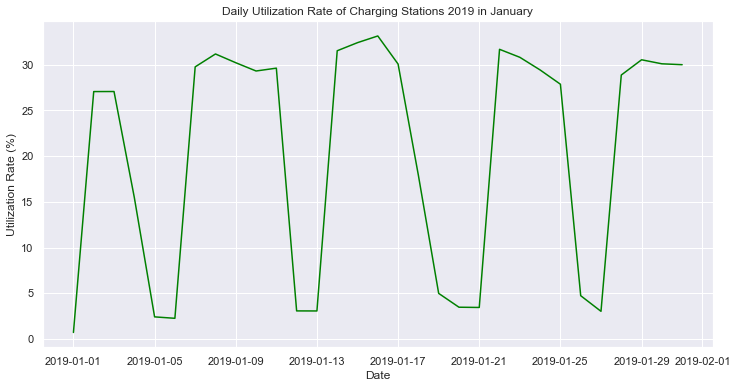

In [255]:
daily_utilization_df = calculate_daily_utilization_rate(df)
daily_utilization_df.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
daily_utilization_df['utilization_rate'].plot(kind='line', color='green')
plt.title("Daily Utilization Rate of Charging Stations")
plt.xlabel("Date")
plt.ylabel("Utilization Rate (%)")
plt.grid(True)
plt.show()

daily_utilization_2019 = calculate_daily_utilization_rate(df[(df['connectionTime'].dt.year == 2019) & (df['connectionTime'].dt.month == 1)])
daily_utilization_2019.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
daily_utilization_2019['utilization_rate'].plot(kind='line', color='green')
plt.title("Daily Utilization Rate of Charging Stations 2019 in January")
plt.xlabel("Date")
plt.ylabel("Utilization Rate (%)")
plt.grid(True)
plt.show()

The daily utilization of the charging station shows a cyclical pattern that can be seen very clearly if you zoom in on a month (e.g. January 2019). The utilization rate often peaks and then drops to zero. This behavior corresponds to the typical usage on weekdays and the lower activity on weekends.

### Utilization Rate per hours a day

The hourly utilization rate provides a detailed view of when the charging station is at capacity and when not. With this metric the operator can identify peak usage times which could help to manage capacity during these hours. High hourly utilization can create spikes in energy demand. Therefore this information could help grid operators to prepare for load fluctuations.

In [256]:
# Calculates the utilization rate of charging stations for a given date per hour
def calculate_utilization_rate_hourly(data, date):
    daily_data = data[data['connectionTime'].dt.date == pd.to_datetime(date).date()]
    total_stations = data['stationID'].nunique()

    hourly_usage_count = [0] * 24

    # iterate over daily_data
    for _, row in daily_data.iterrows():
        start_hour = row['connectionTime'].hour
        end_hour = row['disconnectTime'].hour
        for i in range(start_hour, end_hour):
            hourly_usage_count[i] += 1

    # calculate utilization rate
    hourly_utilization_rate = [(count / total_stations) * 100 for count in hourly_usage_count]

    return hourly_utilization_rate

# calculate the average utilization rate per hour
def calculate_avg_hourly_utilization_rate(data):
    hourly_utilization = []
    unique_dates = data['connectionTime'].dt.date.unique()
    
    for date in unique_dates:
        utilization_rate = calculate_utilization_rate_hourly(data, date)
        hourly_utilization.append(utilization_rate)
    
    hourly_utilization_df = pd.DataFrame(hourly_utilization, columns=range(24))
    avg_hourly_utilization = hourly_utilization_df.mean()
    
    return avg_hourly_utilization

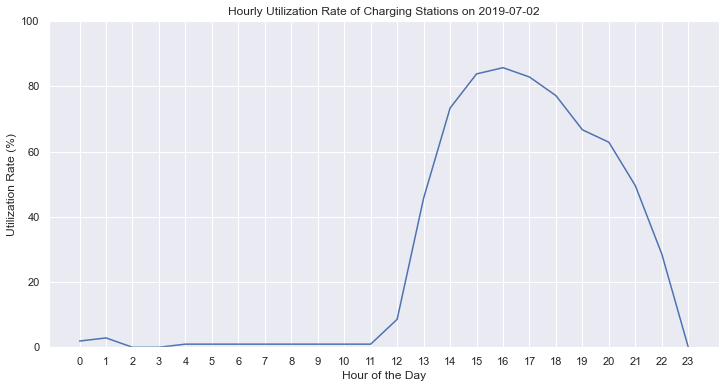

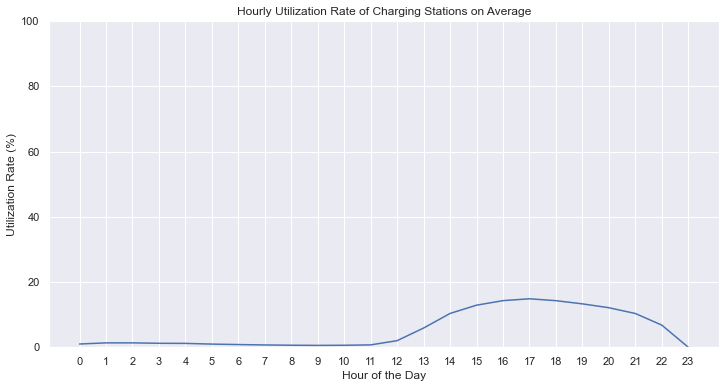

In [257]:
# Calculate hourly utilization rate for a specific date
date = '2019-07-02' 
hourly_utilization_rate = calculate_utilization_rate_hourly(df, date)

plt.figure(figsize=(12, 6))
plt.plot(range(24), hourly_utilization_rate, linestyle='-', color='b')
plt.title(f'Hourly Utilization Rate of Charging Stations on {date}')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization Rate (%)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.ylim(0, 100)
plt.show()

hourly_utilization_rate_avg_year = calculate_avg_hourly_utilization_rate(df)

plt.figure(figsize=(12, 6))
plt.plot(range(24), hourly_utilization_rate_avg_year, linestyle='-', color='b')
plt.title(f'Hourly Utilization Rate of Charging Stations on Average')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization Rate (%)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.ylim(0, 100)
plt.show()

When comparing a specific date with an exceptionally high utilization rate (02.07.2019) with the average utilization rate across all observations, we can definitely see a peak in usage in the afternoon. The specific day's data shows a peak between 14:00 and 18:00, while the average data shows a more consistent pattern with a similar peak time but less extreme variance. this suggests that while there are consistent peak times, individual days may vary. The consistently low usage during off-peak hours in both charts indicates an opportunity to optimize the charging infrastructure.

## C)

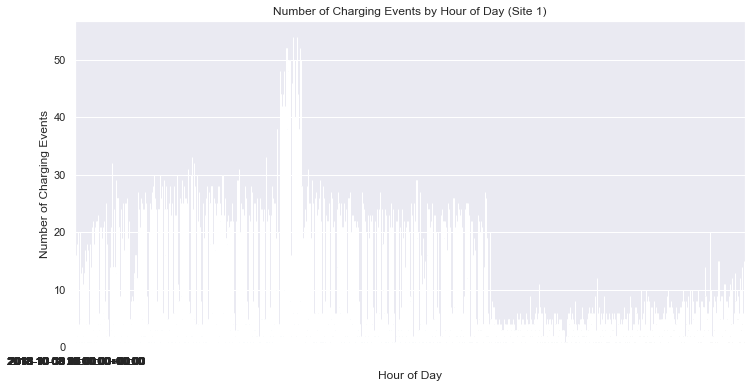

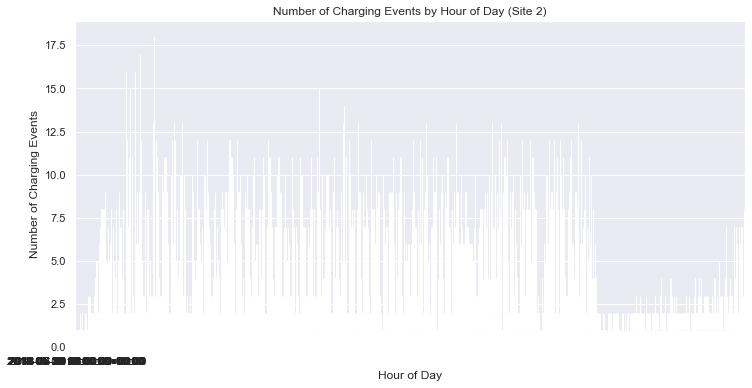

In [258]:
# Filter the dataframe for siteID=1 and siteID=2
df_site1 = df[df['siteID'] == 1]
df_site2 = df[df['siteID'] == 2]

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=df_site1.groupby('hour').size().reset_index(name='Charging Events'), palette='Blues_d')
plt.title('Number of Charging Events by Hour of Day (Site 1)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=df_site2.groupby('hour').size().reset_index(name='Charging Events'), palette='Greens_d')
plt.title('Number of Charging Events by Hour of Day (Site 2)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

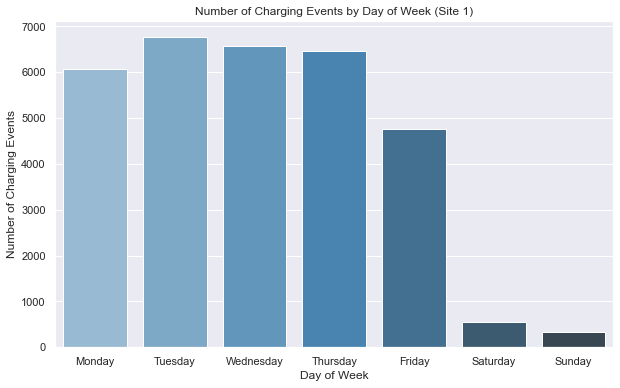

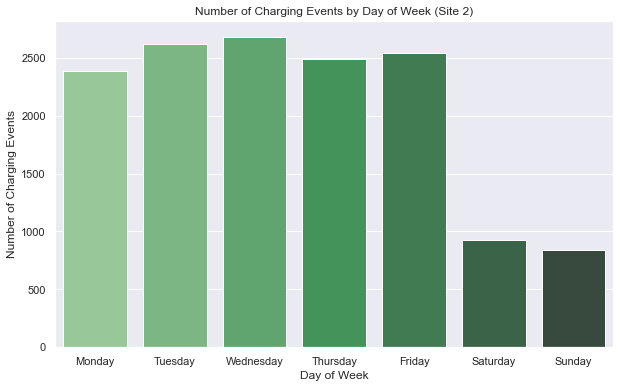

In [259]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts['dayName'] = pd.Categorical(weekly_counts['dayName'], categories=order, ordered=True)
weekly_counts = weekly_counts.sort_values('dayName')

# Group by dayName and count the number of charging events
weekly_counts_site1 = df_site1.groupby('dayName').size().reset_index(name='Charging Events')

# Ensure the days are in the correct order
weekly_counts_site1['dayName'] = pd.Categorical(weekly_counts_site1['dayName'], categories=order, ordered=True)
weekly_counts_site1 = weekly_counts_site1.sort_values('dayName')

# Plot the number of charging events by day of week for siteID=1
plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Charging Events', data=weekly_counts_site1, palette='Blues_d')
plt.title('Number of Charging Events by Day of Week (Site 1)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.show()

# Group by dayName and count the number of charging events for siteID=2
weekly_counts_site2 = df_site2.groupby('dayName').size().reset_index(name='Charging Events')

# Ensure the days are in the correct order
weekly_counts_site2['dayName'] = pd.Categorical(weekly_counts_site2['dayName'], categories=order, ordered=True)
weekly_counts_site2 = weekly_counts_site2.sort_values('dayName')

# Plot the number of charging events by day of week for siteID=2
plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Charging Events', data=weekly_counts_site2, palette='Greens_d')
plt.title('Number of Charging Events by Day of Week (Site 2)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.show()


The number of charging events compared for both sides, reveals which side is the private one. For site 2 the number of charging events is about 4 times higher during weekdays, than for site 1, which suggests that site 2 is the public side due to more public vehicle renting. Since station 1 has low utilization on weekend, this station is probably the privat one.

# Clustering

To identify groups of archetypical charging events we apply clustering. We select the features 'charging_duration', 'session_duration', 'idleTime', and 'kWhDelivered', since these are the numerical data that describe the charging process

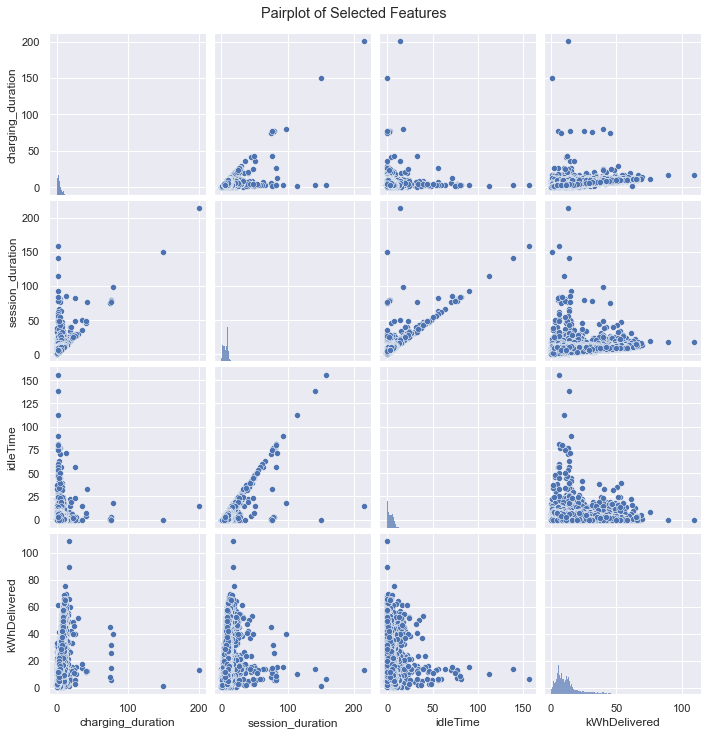

In [260]:
df["idleTime"] = (df["disconnectTime"] - df["doneChargingTime"]).dt.total_seconds() / 3600

features = ['charging_duration', 'session_duration', 'idleTime', 'kWhDelivered']
df_numerical = df[features]

sns.pairplot(df_numerical)
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

As observed in the pairplot, the dataset contains outliers that could negatively impact the clustering process. To address this we, identify and remove outliers using the 3 sigma threshold

In [261]:
# Calculate mean and standard deviation for each feature
mean = df_numerical.mean()
std = df_numerical.std()

# Define the 3-sigma range
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Filter out points that fall outside the 3-sigma range
df_clustering = df_numerical[
    (df_numerical >= lower_bound) & (df_numerical <= upper_bound)
].dropna()

print(f'Original number of points: {len(df_numerical)}')
print(f'Number of points after 3-sigma filtering: {len(df_clustering)}')

Original number of points: 46007
Number of points after 3-sigma filtering: 44789


We decided to implement soft clustering due to the significant overlap in the data, as hard clustering was not appropriate for this scenario. Hard clustering methods, such as K-Means, assign each data point to a single cluster, which can lead to inaccurate results when clusters overlap. In contrast, we chose the Gaussian Mixture Model (GMM) because it provides probabilistic cluster assignments, allowing data points to belong to multiple clusters with varying probabilities

To ensure that all features contribute equally to the clustering process, we scale the data before fitting the model. We then determine the optimal number of clusters by evaluating different model configurations using the Bayesian Information Criterion (BIC). This score penalizes the addition of extra parameters to avoid overfitting.

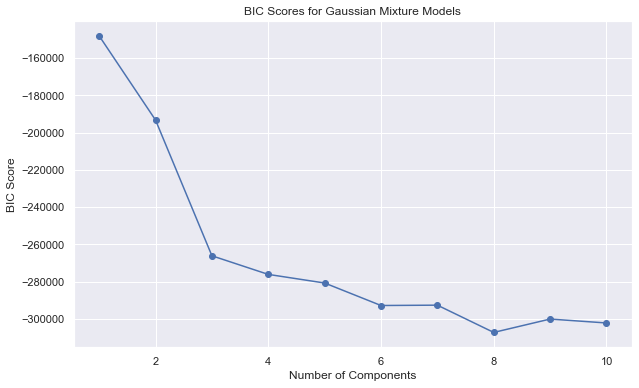

In [262]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# Determine the optimal number of clusters using BIC
bic_scores = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for Gaussian Mixture Models')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

The elbow method suggests choosing 3 clusters, as the model fit improves significantly slower from that point on.

In [263]:
# Fit the GMM with the optimal number of cluters
optimal_components = 3
best_gmm = GaussianMixture(n_components=optimal_components, random_state=42)
best_gmm.fit(X_scaled)
df_clustering['cluster'] = best_gmm.predict(X_scaled)

<Figure size 864x720 with 0 Axes>

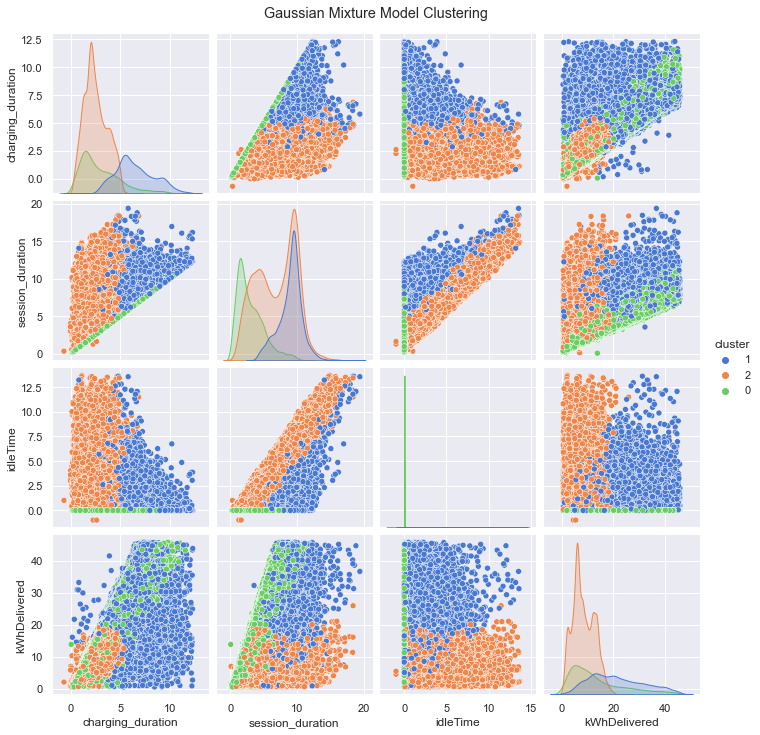

Cluster Summary: mean of features
         charging_duration  session_duration  idleTime  kWhDelivered
cluster                                                             
0                 3.001856          2.998954 -0.002902     13.494390
1                 6.472588          8.927924  2.455336     21.279434
2                 2.496576          6.824878  4.328302      8.330656


In [264]:
# Add cluster labels to the original dataset
df['cluster'] = -1  # Default cluster for rows dropped due to NaN
if len(df_clustering) > 0:
    df.loc[df_clustering.index, 'cluster'] = df_clustering['cluster']

# Visualize the clusters using pairplot
plt.figure(figsize=(12, 10))
sns.pairplot(df_clustering.assign(cluster=df_clustering['cluster'].astype(str)), 
             vars=features, hue='cluster', palette='muted', diag_kind='kde')
plt.suptitle('Gaussian Mixture Model Clustering', y=1.02)
plt.show()

# Generate descriptive statistics for each cluster
cluster_summary = df_clustering.groupby('cluster')[features].mean()
print("Cluster Summary: mean of features")
print(cluster_summary)


## Names for clusters


Cluster 1 (Blue): Extended Stay
- Longer charging sessions with significant idle time

Cluster 2 (Orange): Slow Overnight Charge
- Long charging durations with low kWh delivery, which suggests charging over night

Cluster 3 (Green): Fast Charging Peak
- Short charging sessions with high kWh delivered, and short idle time

By identifying the different types of charging operations, the operator can gain valuable insights that can help them make decisions. This could improve resource allocation and load management. Fast charging peaks may require more energy capacity, while night-time charging may be less demanding. Charging networks can use this data to optimize grid management and ensure that sufficient energy is available at peak times. 

# Prediction

In [265]:

df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600
# Calculate utilization rate as % of day 
df['utilization_rate'] = (df['session_duration'] / 24) * 100

df['hour'] = df['connectionTime'].dt.hour
df['day_of_week'] = df['connectionTime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
#Take avg of current and previous two sessions
df['hourly_energy_rolling'] = df['kWhDelivered'].rolling(window=3, min_periods=1).mean()
# Information about past session energy, allowing to account for recent util. patterns
df['prev_session_energy'] = df['kWhDelivered'].shift(1).fillna(0)
#Independent features
X_full = df[['siteID', 'hour', 'day_of_week', 'month', 'year', 
             'session_duration', 'is_weekend', 'hourly_energy_rolling', 
             'prev_session_energy']]
#Target 
y_full = df['utilization_rate']  

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['siteID', 'day_of_week', 'month'])
    ],
    remainder='passthrough'
)

# Train initial model with limited depth, max depth of 8 for explainability and prevent overfitting
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=8, random_state=42))  # Limit depth to avoid huge trees
])

pipeline_dt.fit(X_train, y_train)

# Evaluate initial model
y_pred_train = pipeline_dt.predict(X_train)
y_pred_test = pipeline_dt.predict(X_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f'Train MAE: {mae_train:.2f} %')
print(f'Test MAE: {mae_test:.2f} %')
print(f'Train R²: {r2_train:.2f}')
print(f'Test R²: {r2_test:.2f}')

# Rank Feature importance
feature_importances = pd.Series(
    pipeline_dt.named_steps['model'].feature_importances_,
    index=pipeline_dt.named_steps['preprocessor'].get_feature_names_out()
).sort_values(ascending=False)

print(feature_importances)

# Filter important features (threshold > 0.11) to simplify
threshold = 0.11
important_features = feature_importances[feature_importances > threshold].index

# Transform X_train and X_test
X_train_transformed = pipeline_dt.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline_dt.named_steps['preprocessor'].transform(X_test)
# Mask to keep only important features
mask = [name in important_features for name in pipeline_dt.named_steps['preprocessor'].get_feature_names_out()]
X_train_filtered = X_train_transformed[:, mask]
X_test_filtered = X_test_transformed[:, mask]

# Extract filtered feature names
filtered_feature_names = [name for name, keep in zip(
    pipeline_dt.named_steps['preprocessor'].get_feature_names_out(), mask) if keep]

# model retraining on the filtered/important data
final_model = DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_leaf=10, min_samples_split=20)
final_model.fit(X_train_filtered, y_train)

# Re-evaluate model with limited complexity
y_pred_train = final_model.predict(X_train_filtered)
y_pred_test = final_model.predict(X_test_filtered)
mae_filtered_train = mean_absolute_error(y_train, y_pred_train)
mae_filtered_test = mean_absolute_error(y_test, y_pred_test)
r2_filtered_train = r2_score(y_train, y_pred_train)
r2_filtered_test = r2_score(y_test, y_pred_test)
print(f'Filtered Train MAE: {mae_filtered_train:.2f} %')
print(f'Filtered Test MAE: {mae_filtered_test:.2f} %')
print(f'Filtered Train R²: {r2_filtered_train:.2f}')
print(f'Filtered Test R²: {r2_filtered_test:.2f}')

tree_rules = export_text(final_model, 
                         feature_names=filtered_feature_names,
                         max_depth=5)  
print(tree_rules)
plt.figure(figsize=(20, 10))


plot_tree(final_model, 
          feature_names=filtered_feature_names, 
          filled=True, rounded=True)
plt.show()

Train MAE: 0.14 %
Test MAE: 0.21 %
Train R²: 1.00
Test R²: 0.96


AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'